# Introduction

In this Jupyter Notebook we importing the ENTSO-E Actual Generation per Type data (processed with OPSD time series script) and correcting the hourly data with reported yearly values from ENTSO-E statistical factsheet.

The OPSD time series script converts all data to one resolution (1 hour) and interpolate gaps in the datat set with a max length of 2 hours. 

# Script setup

In [1]:
import numpy as np
import pandas as pd

#Helpers
import os
import glob
from datetime import datetime, date, timedelta, time


#Ploting
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

# Data directory preparention

Create input, processed and output folders if they don't exist. If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final data

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

sources_yaml_path = os.path.join('input', 'sources.yml')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preparation

1. ENTSO-E Transparency Platform, Actual Generation per Type Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show (accessed on Oct 02, 2020).
 - Proccesed with OPSD time series scrips (own version INETCH)
 time_series_60min_stacked.csv
 
2. ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV) format
https://zenodo.org/record/3461691


Original data: ENTSO-E statistics Available online:
https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet

 File - > entsoe-statistical-factsheet-2018-stacked



Previously we used the Energy Balances in the MS Excel file format (2020 edition) eurostat https://ec.europa.eu/eurostat/de/web/energy/data/energy-balances (accessed on Oct 02, 2020). The Energy Balance data only provides gross electricity data.

# Load data functions

In [3]:
def load_timeseries_opsd(fn):
    """
    Read data from OPSD time-series package own modification.

    Parameters
    ----------
    years : None or slice()
        Years for which to read load data
        
    fn : file name or url location (file format .csv)
    
    countries : Countries for which to read load data.
        
    Returns
    -------
    load : pd.DataFrame
        Load time-series with UTC timestamps x ISO-2 countries
    """

     
    generation = pd.read_csv(fn, index_col='utc_timestamp', parse_dates=True) #, header=[0, 1, 2, 3, 4, 5], parse_dates=True)
                    #.dropna(how="all", axis=0)  
        
    #generation.columns = generation.columns.droplevel(level=[2,3,4,5])
    #generation = generation[~generation['region'].str.contains("_")]

    generation = generation.drop(columns='attribute')
    
    return generation

def load_stats_factsheet(path, fn):
    """
    Load the ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV).
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),index_col=[0], header=[0, 1], parse_dates=True)
    
    return generation

def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_info(path, fn):
    """
    Load the ENTSO-E generation unit information.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    
    # set name for the index
    df.index.set_names('GenerationUnitEIC', inplace=True)

    return df

In [4]:
def convert_ENTSOE_to_INATECH_type(ProductionTypeName):
    """
    Converts ENTSO-E Generation per Type source names into INATECH technology type names.

    Parameters
    ----------
    ProductionTypeName : string
        ENTSO-E name of production type.

    Returns
    -------
    string
        INATECH names of production type.

    """

    return ProductionTypeName.replace({
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}, inplace=False)

# Load and filter data¶

In [5]:
# period filter
start = '2018-01-01 00:00:00+00:00'
end = '2018-12-31 23:00:00+00:00'

## load data timeseries_opsd

In [6]:
# load data
entsoe_gen_type = load_timeseries_opsd(fn=input_directory_path + '/time_series_60min_stacked.csv')

In [7]:
entsoe_gen_type = entsoe_gen_type.loc[start:end].copy()

In [8]:
# show the data set
entsoe_gen_type

,region,variable,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,AT,Biomass,316.0
2018-01-01 01:00:00+00:00,AT,Biomass,316.0
2018-01-01 02:00:00+00:00,AT,Biomass,316.0
2018-01-01 03:00:00+00:00,AT,Biomass,316.0
2018-01-01 04:00:00+00:00,AT,Biomass,316.0
...,...,...,...
2018-12-31 19:00:00+00:00,SK,Solar,0.4
2018-12-31 20:00:00+00:00,SK,Solar,0.2
2018-12-31 21:00:00+00:00,SK,Solar,0.2


In [9]:
entsoe_gen_type.isna().any()

region      False
variable    False
data        False
dtype: bool

## load and standardize data Stats FACT

In [10]:
# load data
entsoe_stats = load_stats_factsheet(input_directory_path, 'Stats_FACT_table.csv')

In [11]:
# show the data set
entsoe_stats

country         AL                                                         \
source     biomass  gas hard_coal      hydro lignite nuclear other_fossil   
year                                                                        
2018-01-01     0.0  0.0       0.0  8100000.0     0.0     0.0          0.0   

country                                 ...          TR              \
source     other_renewable solar waste  ...   hard_coal       hydro   
year                                    ...                           
2018-01-01             0.0   0.0   0.0  ...  67800000.0  59800000.0   

country                                                                       \
source         lignite nuclear other_fossil other_renewable      solar waste   
year                                                                           
2018-01-01  44800000.0     0.0    1400000.0       6900000.0  7200000.0   0.0   

country                                
source     wind_offshore wind_onshore  
year                                   
2018-01-01           0.0   19900000.0  

[1 rows x 432 columns]

## standardize data

In [12]:
# available countries in entsoe stats data set
countries = entsoe_stats.columns.levels[0].to_list()

In [13]:
countries

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FR',
 'GB',
 'GR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR']

In [14]:
entsoe_gen_type.region.unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DE_50hertz', 'DE_LU',
       'DE_amprion', 'DE_tennet', 'DE_transnetbw', 'DK', 'DK_1', 'DK_2',
       'DK_energinet', 'EE', 'ES', 'FI', 'FR', 'GB_GBN', 'GB_NIR',
       'GB_UKM', 'GR', 'HU', 'IE', 'IE_sem', 'IT', 'IT_BRNN', 'IT_CNOR',
       'IT_CSUD', 'IT_FOGN', 'IT_NORD', 'IT_PRGP', 'IT_ROSN', 'IT_SARD',
       'IT_SICI', 'IT_SUD', 'LT', 'LV', 'ME', 'NL', 'NO', 'NO_1', 'NO_2',
       'NO_3', 'NO_4', 'NO_5', 'PL', 'PT', 'RO', 'RS', 'SE', 'SE_1',
       'SE_2', 'SE_3', 'SE_4', 'SI', 'SK'], dtype=object)

In [15]:
# replace region GB_UKM with GB
entsoe_gen_type.region = entsoe_gen_type.region.replace({'GB_UKM' : 'GB'})

In [16]:
# filter entso e data
entsoe_gen_type.query('region in @countries', inplace= True)

In [17]:
entsoe_gen_type.variable.unique()

array(['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Other', 'Solar', 'Waste', 'Wind Onshore',
       'Fossil Oil', 'Nuclear', 'Wind Offshore',
       'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas',
       'Other renewable', 'Fossil Peat'], dtype=object)

In [18]:
# change ProductionTypeNames into INATECH technology type names
entsoe_gen_type.variable = convert_ENTSOE_to_INATECH_type(entsoe_gen_type.variable)

In [19]:
entsoe_gen_type.variable.unique()

array(['biomass', 'gas', 'hard_coal', 'other_renewable', 'hydro',
       'other_fossil', 'solar', 'waste', 'wind_onshore', 'nuclear',
       'wind_offshore', 'lignite'], dtype=object)

In [20]:
# after changing the production type we need to group the dataset
# reset index for groupby function
entsoe_gen_type.reset_index(inplace=True)
# group same production types
entsoe_gen_type = entsoe_gen_type.groupby(['variable', 'utc_timestamp','region']).sum()
# set the old index for the dataframe
entsoe_gen_type = entsoe_gen_type.reset_index().set_index('utc_timestamp')

In [21]:
# show the head of the data set 
entsoe_gen_type.head(10)

,variable,region,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,biomass,AT,316.00
2018-01-01 00:00:00+00:00,biomass,BE,232.46
2018-01-01 00:00:00+00:00,biomass,BG,28.00
2018-01-01 00:00:00+00:00,biomass,CZ,261.78
2018-01-01 00:00:00+00:00,biomass,DE,4764.00
2018-01-01 00:00:00+00:00,biomass,DK,587.00
2018-01-01 00:00:00+00:00,biomass,EE,71.10
2018-01-01 00:00:00+00:00,biomass,ES,275.00
2018-01-01 00:00:00+00:00,biomass,FI,855.71


In [22]:
# convert entso data into table format
entsoe_gen_type_table =  pd.pivot_table(entsoe_gen_type, values='data', index=entsoe_gen_type.index, columns=['region','variable'])

In [23]:
entsoe_gen_type_table.head()

region                         AT                                       \
variable                  biomass   gas hard_coal   hydro other_fossil   
utc_timestamp                                                            
2018-01-01 00:00:00+00:00   316.0  71.0     150.0  3345.0         22.0   
2018-01-01 01:00:00+00:00   316.0  70.0     149.0  3275.0         22.0   
2018-01-01 02:00:00+00:00   316.0  69.0     149.0  3167.0         22.0   
2018-01-01 03:00:00+00:00   316.0  72.0     149.0  3160.0         22.0   
2018-01-01 04:00:00+00:00   316.0  75.0     149.0  3330.0         22.0   

region                                                                   BE  \
variable                  other_renewable solar  waste wind_onshore biomass   
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00             0.0   0.0  100.0        832.0  232.46   
2018-01-01 01:00:00+00:00             0.0   0.0  100.0        926.0  153.58   
2018-01-01 02:00:00+00:00             0.0   0.0  100.0        692.0  133.70   
2018-01-01 03:00:00+00:00             0.0   0.0  100.0        453.0  131.38   
2018-01-01 04:00:00+00:00             0.0   0.0  100.0        321.0  131.26   

region                     ...           SI      SK                           \
variable                   ... wind_onshore biomass    gas hard_coal   hydro   
utc_timestamp              ...                                                 
2018-01-01 00:00:00+00:00  ...         0.70    28.2  175.6      48.1  455.93   
2018-01-01 01:00:00+00:00  ...         0.61    28.1  172.9      48.0  461.95   
2018-01-01 02:00:00+00:00  ...         0.57    28.1  162.1      46.7  513.39   
2018-01-01 03:00:00+00:00  ...         0.62    29.7  140.3      45.3  587.83   
2018-01-01 04:00:00+00:00  ...         0.56    29.5  143.5      46.4  562.89   

region                                                                        
variable                  lignite nuclear other_fossil other_renewable solar  
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00   179.5  1819.3        478.8            41.4   0.0  
2018-01-01 01:00:00+00:00   177.9  1816.7        475.8            41.0   0.0  
2018-01-01 02:00:00+00:00   174.7  1808.7        469.5            40.8   0.0  
2018-01-01 03:00:00+00:00   168.5  1803.6        455.6            39.4   0.0  
2018-01-01 04:00:00+00:00   170.6  1809.1        461.5            40.4   0.0  

[5 rows x 214 columns]

## Check entsoe generation data for nan

In [24]:
def consecutive_nans(ds):
    return (ds.isnull().astype(int)
            .groupby(ds.notnull().astype(int).cumsum()[ds.isnull()])
            .transform('sum').fillna(0))

def nan_statistics(df):
    def max_consecutive_nans(ds):
        return (ds.isnull().astype(int)
                  .groupby(ds.notnull().astype(int).cumsum())
                  .sum().max())
    consecutive = df.apply(max_consecutive_nans)
    total = df.isnull().sum()
    max_total_per_month = df.isnull().resample('m').sum().max()
    return pd.concat([total, consecutive, max_total_per_month],
                 keys=['total', 'consecutive', 'max_total_per_month'], axis=1)

def change_multiindex(df):
    df = df.copy(deep=True)
    if df.columns.nlevels > 1:
        df.columns = [' '.join(col).strip() for col in df.columns.values]
    else:
        pass
    
    return df

# plot function
def plot_gap_map_func(data):

    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(15, 10))

    # plot data gaps
    sns.heatmap(data, cmap='Blues', robust=False, cbar=True, ax=ax, yticklabels=True)
    
    # set x ticks
    ax.set_xticks(list(range(0, 8760,1000)))
    # set x labels
    ax.set_xticklabels(range(0, 8760,1000), rotation=0)
    
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16, rotation=45)

    # use matplotlib.colorbar.Colorbar object
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('Gaps', fontsize=20)
    

    
    ax.set_xlabel("Hour of the year", fontsize=20)
    ax.set_ylabel("Country", fontsize=20)
    
    

    # draw hline for seperation
    ax.hlines(list(range(len(data.index))), colors='k', *ax.get_xlim(),  linewidth=1.5, alpha=0.5)

    #draw border for figure
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('1.5')  
    
    fig.tight_layout()

    return fig

In [25]:
# nan statistic for generation data
nan_statistic = nan_statistics(change_multiindex(entsoe_gen_type_table))

In [26]:
# minimum 
nan_statistic[nan_statistic > 0].min()

total                  3.0
consecutive            3.0
max_total_per_month    3.0
dtype: float64

In [27]:
# maximum 
nan_statistic[nan_statistic > 0].max()

total                  6457.0
consecutive            5327.0
max_total_per_month     744.0
dtype: float64

In [28]:
len(entsoe_gen_type_table.columns.levels[1])

12

In [29]:
# export statistic to csv file
nan_statistic.to_csv(output_directory_path + '/nan_statistic.csv')

In [30]:
# nan dataframe for nan plot
# nan for each technology
entsoe_gen_type_table_null = entsoe_gen_type_table.isnull()

plot_table_null = entsoe_gen_type_table_null.groupby(level = 0, axis = 1).sum() / entsoe_gen_type_table_null.count(axis=1, level=0)

plot_table_null = plot_table_null.T

In [31]:
plot_table_null.head()

utc_timestamp,2018-01-01 00:00:00+00:00,2018-01-01 01:00:00+00:00,2018-01-01 02:00:00+00:00,2018-01-01 03:00:00+00:00,2018-01-01 04:00:00+00:00,2018-01-01 05:00:00+00:00,2018-01-01 06:00:00+00:00,2018-01-01 07:00:00+00:00,2018-01-01 08:00:00+00:00,2018-01-01 09:00:00+00:00,...,2018-12-31 14:00:00+00:00,2018-12-31 15:00:00+00:00,2018-12-31 16:00:00+00:00,2018-12-31 17:00:00+00:00,2018-12-31 18:00:00+00:00,2018-12-31 19:00:00+00:00,2018-12-31 20:00:00+00:00,2018-12-31 21:00:00+00:00,2018-12-31 22:00:00+00:00,2018-12-31 23:00:00+00:00
region,,,,,,,,,,,,,,,,,,,,,
AT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


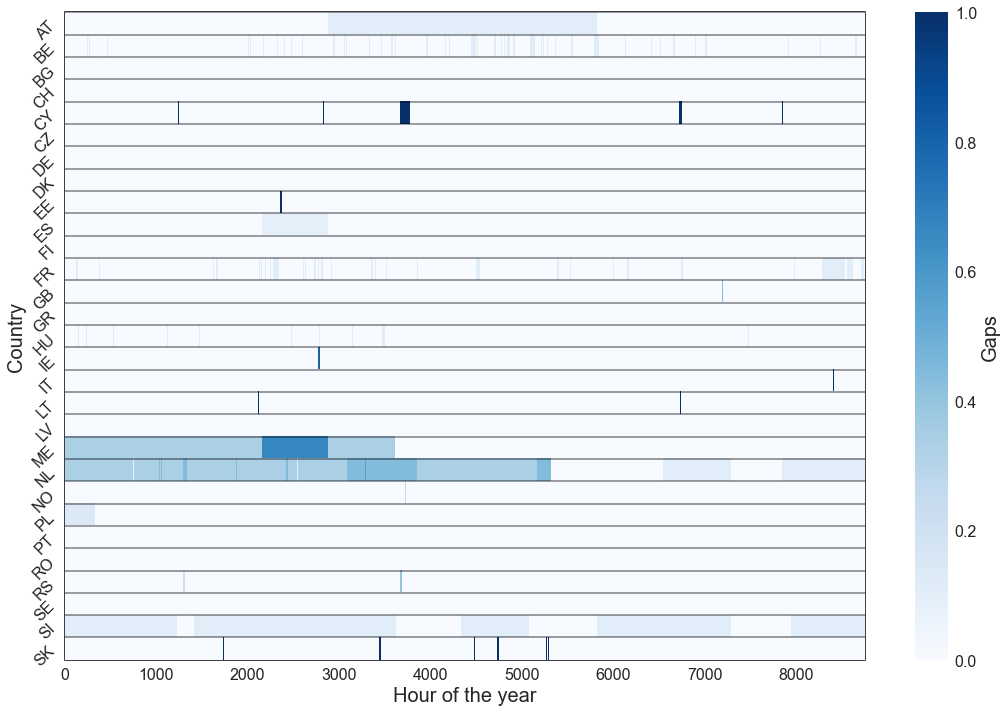

In [32]:
fig = plot_gap_map_func(plot_table_null)

fig.savefig(os.path.join(output_directory_path + '/generation_per_tech_nan_gap_map_orig.jpg'))

## Manual adjustment of entsoe generation data 

We using some external sources to adjust the hourly production data for some countries.

- 1) ENTSO-E production per unit

Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution:

- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

### Load power plant unit generation and inforamtion (capacity, name, etc.)

In [33]:
generation_per_unit_2018 = load_generation_per_unit(input_directory_path, 'gen_data_2018.csv')
generation_unit_info = load_unit_info(input_directory_path, 'unit_data_2018.csv')

In [34]:
# set same index for both dataframes
generation_per_unit_2018 = generation_per_unit_2018.set_index(entsoe_gen_type_table.index)

### Sweden

Overview of Swedisch genertaion units in ENTSO-E generation per unit.

In [35]:
generation_unit_info[(generation_unit_info.MapCode == 'SE')]

,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,MapCode,PowerSystemResourceName,ProductionTypeName,ProductionUnitEIC,duplicate_count
GenerationUnitEIC,,,,,,,,,
46WGU00000000305,10YSE-1--------K,SvK CA,CTA,150.0,SE,Messaure G1,hydro,46WPU0000000032W,1.0
46WGU0000000034Y,10YSE-1--------K,SvK CA,CTA,225.0,SE,Seitevare G1,hydro,46WPU0000000033U,1.0
46WGU0000000045T,10YSE-1--------K,SvK CA,CTA,171.0,SE,Stornorrfors G4,hydro,46WPU0000000042T,1.0
46WGU0000000044V,10YSE-1--------K,SvK CA,CTA,136.0,SE,Stornorrfors G3,hydro,46WPU0000000042T,1.0
46WGU0000000137O,10YSE-1--------K,SvK CA,CTA,492.0,SE,Forsmark block 1 G11,nuclear,46WPU0000000015W,2.0
46WGU0000000017Y,10YSE-1--------K,SvK CA,CTA,0.0,SE,Karlshamn G1,other_fossil,46WPU0000000005Z,1.0
46WGU00000000208,10YSE-1--------K,SvK CA,CTA,320.0,SE,Ritsem G1,hydro,46WPU0000000026R,1.0
46WGU0000000026X,10YSE-1--------K,SvK CA,CTA,110.0,SE,Harsprånget G2,hydro,46WPU0000000029L,1.0
46WGU0000000027V,10YSE-1--------K,SvK CA,CTA,170.0,SE,Harsprånget G4,hydro,46WPU0000000029L,1.0


In [36]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['ES'].sum())
print('total: ' + str(entsoe_gen_type_table['ES'].sum().sum()))

variable
biomass             2951320.0
gas                50970105.0
hard_coal          32347867.5
hydro              36130459.0
lignite             3091189.0
nuclear            53278071.5
other_fossil        2940224.0
other_renewable      857555.5
solar              12024589.5
waste               2616967.5
wind_onshore       48917756.0
dtype: float64
total: 246126104.5


In [37]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['SE'].sum())
print('total: ' + str(entsoe_stats['SE'].sum().sum()))

source
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
hydro              61000000.0
lignite                   0.0
nuclear            65800000.0
other_fossil        1700000.0
other_renewable     1300000.0
solar                     0.0
waste                900000.0
wind_offshore             0.0
wind_onshore       16600000.0
dtype: float64
total: 158200000.0


If we compare both data sets, we can see that per type generation has less generation technologies than the ENTSO-E fact sheet. But the total generation of both data set is similar. We assume that the generation from missing technologies are incorrectly assigned in the per type generation data.
To corrode this we assume:
1. That the generation of biomass (9800 GWh from fact sheet) is assigned to the tech type "other_fossil" in the generation per type
2. That gas generation (600 GWh from fact sheet) is missing in the generation per type data
3. That hard coal generation (500 GWh from fact sheet) is missing in the generation per type data
4. That other_renewable (1300 GWH from fact sheet) is missing in the generation per type data
5. That other_fossil (1700 GWH from fact sheet) is not correctly represented because about wrong assignment with biomass
6. That waste (900 GWh from fact sheet) is missing in the generation per type data

Correction steps:

In [38]:
# 1. With the use of two biomass power plant generation series from ENTSO-E per unit generation and 90% of the other_fossil generation from ENTSO-E per type we build biomass generation. 
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'biomass')].index

entsoe_gen_type_table['SE', 'biomass'] = (generation_per_unit_2018[index].sum(axis=1) + (entsoe_gen_type_table['SE', 'other_fossil'] * 0.9)).copy()

In [39]:
# 2. With the use of one gas power plant generation series from ENTSO-E per unit generation we build gas generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'gas')].index

entsoe_gen_type_table['SE', 'gas'] = generation_per_unit_2018[index].sum(axis=1).copy()

In [40]:
# 3. With the use of one hard_coal power plant generation series from ENTSO-E per unit generation we build hard_coal generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'hard_coal')].index

entsoe_gen_type_table['SE', 'hard_coal'] = generation_per_unit_2018[index].sum(axis=1).copy()

In [41]:
# 4. Other_renewable is missing in all hourly dataset. By using the same generation profile as other_fossil (10%) and later scaling to the value of the fact sheet.
entsoe_gen_type_table['SE', 'other_renewable'] = (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1).copy()

In [42]:
# 5. With the use of 8 other_fossil power plant generation series from ENTSO-E per unit generation and 10% of the other_fossil generation from ENTSO-E per type we build other_foosil generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'other_fossil')].index

entsoe_gen_type_table['SE', 'other_fossil'] = (generation_per_unit_2018[index].sum(axis=1) + (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1)).copy()

In [43]:
# 6. With the use of 10% of the other_fossil generation from ENTSO-E per type we build waste generation.
entsoe_gen_type_table['SE', 'waste'] = (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1).copy()

In [44]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['SE'].sum())
print('total: ' + str(entsoe_gen_type_table['SE'].sum().sum()))

variable
hydro              6.211010e+07
nuclear            6.578728e+07
other_fossil       1.022170e+06
wind_onshore       1.630541e+07
biomass            8.116121e+06
gas                4.082863e+05
hard_coal          3.784609e+05
other_renewable    8.334513e+05
waste              1.022170e+05
dtype: float64
total: 155063494.205


In [45]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['SE'].sum())
print('total: ' + str(entsoe_stats['SE'].sum().sum()))

source
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
hydro              61000000.0
lignite                   0.0
nuclear            65800000.0
other_fossil        1700000.0
other_renewable     1300000.0
solar                     0.0
waste                900000.0
wind_offshore             0.0
wind_onshore       16600000.0
dtype: float64
total: 158200000.0


### Italy

Overview of Italy generation units in ENTSO-E generation per unit.

In [46]:
generation_unit_info[(generation_unit_info.MapCode == 'IT')]

,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,MapCode,PowerSystemResourceName,ProductionTypeName,ProductionUnitEIC,duplicate_count
GenerationUnitEIC,,,,,,,,,
26WUUUFUSINA-T42,10YIT-GRTN-----B,Italy CA,CTA,280.0,IT,UP_FUSINA_T_4,hard_coal,26WIMPI-S05FTSNK,1.0
26WUUUUUUUNOCE1E,10YIT-GRTN-----B,Italy CA,CTA,161.0,IT,UP_NOCE_1,hydro,26WIMPII-NOCE-1C,1.0
26WUUUUUUGISSI19,10YIT-GRTN-----B,Italy CA,CTA,420.0,IT,UP_GISSI_1,gas,26WIMPI-S13CDGNT,1.0
26WUTRRVLDLIGA63,10YIT-GRTN-----B,Italy CA,CTA,390.0,IT,UP_TRRVLDLIGA_6,gas,26WIMPI-S12TRRVU,1.0
26WUUUS-F--DEL16,10YIT-GRTN-----B,Italy CA,CTA,145.0,IT,UP_S.F._DEL_1,other_fossil,26WIMPI-S19SDMCS,1.0
...,...,...,...,...,...,...,...,...,...
26WUCTNUCENORD1T,10YIT-GRTN-----B,Italy CA,CTA,410.0,IT,UP_CTNUCENORD_1,gas,NaN,1.0
26WUTRMVLRZZTR3M,10YIT-GRTN-----B,Italy CA,CTA,99.0,IT,UP_TRMVLRZZTR_3,other_fossil,26WIMPI-S15TDARG,1.0
26WUNPWRRVENNA3F,10YIT-GRTN-----B,Italy CA,CTA,114.0,IT,UP_NPWRRVENNA_3,gas,26WIMPI-S08ERNPQ,1.0


In [47]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['IT'].sum())
print('total: ' + str(entsoe_gen_type_table['IT'].sum().sum()))

variable
biomass             3490127.5
gas                74489448.5
hard_coal          25835965.5
hydro              47619798.0
other_fossil       62413766.5
other_renewable     5700344.5
solar              17793923.0
waste                331551.5
wind_onshore       17314414.5
dtype: float64
total: 254989339.5


In [48]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['IT'].sum())
print('total: ' + str(entsoe_stats['IT'].sum().sum()))

source
biomass             14900000.0
gas                124000000.0
hard_coal           28800000.0
hydro               49500000.0
lignite                    0.0
nuclear                    0.0
other_fossil        13000000.0
other_renewable      7800000.0
solar               22900000.0
waste                2100000.0
wind_offshore              0.0
wind_onshore        17300000.0
dtype: float64
total: 280300000.0


If we compare both data sets, we can see that some per type generation and their order of magnitude does not match the type generation from the factsheet. But the total generation of both data set is similar. We assume that the generation from some technologies are incorrectly assigned in the per type generation data.

To corrode this we assume:
1. That the generation of other_fossil (62413 GWh from per type) is incorrectly assigned and most of the power plants are gas power plants instead.

Correction steps:

In [49]:
# 1. 20% of the other_fossil generation from ENTSO-E per type we build the real other_fossil generation. 
entsoe_gen_type_table['IT', 'other_fossil'] = ((entsoe_gen_type_table['IT', 'other_fossil'] * 0.2)).copy()

In [50]:
# 1. 80% of the other_fossil generation from ENTSO-E per type we build the real gas generation. 
entsoe_gen_type_table['IT', 'gas'] = ((entsoe_gen_type_table['IT', 'other_fossil'] * 0.8) + (entsoe_gen_type_table['IT', 'gas'] * 1)).copy()

In [51]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['IT'].sum())
print('total: ' + str(entsoe_gen_type_table['IT'].sum().sum()))

variable
biomass             3490127.50
gas                84475651.14
hard_coal          25835965.50
hydro              47619798.00
other_fossil       12482753.30
other_renewable     5700344.50
solar              17793923.00
waste                331551.50
wind_onshore       17314414.50
dtype: float64
total: 215044528.93999958


In [52]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['IT'].sum())
print('total: ' + str(entsoe_stats['IT'].sum().sum()))

source
biomass             14900000.0
gas                124000000.0
hard_coal           28800000.0
hydro               49500000.0
lignite                    0.0
nuclear                    0.0
other_fossil        13000000.0
other_renewable      7800000.0
solar               22900000.0
waste                2100000.0
wind_offshore              0.0
wind_onshore        17300000.0
dtype: float64
total: 280300000.0


### Estonia

In [53]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['EE'].sum())
print('total: ' + str(entsoe_gen_type_table['EE'].sum().sum()))

variable
biomass            562051.40
gas                 30592.70
hydro               27273.50
other_fossil       500249.65
other_renewable     53702.80
solar                6117.30
waste              125657.55
wind_onshore       627136.00
dtype: float64
total: 1932780.8999999997


In [54]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['EE'].sum())
print('total: ' + str(entsoe_stats['EE'].sum().sum()))

source
biomass             700000.0
gas                      0.0
hard_coal                0.0
hydro               100000.0
lignite                  0.0
nuclear                  0.0
other_fossil       8800000.0
other_renewable          0.0
solar                    0.0
waste                    0.0
wind_offshore            0.0
wind_onshore        600000.0
dtype: float64
total: 10200000.0


If we compare both data sets, we can see that some per type generation and their order of magnitude does not match the type generation from the factsheet. Also the total generation of both data set are different in one order of magnitude. We assume that the generation from some technologies are incorrectly assigned in the per type generation data.

To corrode this we assume:
1. That other_fossil generation (8800 GWh from fact sheet) is missing in the generation per type data

Correction steps:

In [55]:
# 1. With the use of 13 other_fossil power plant generation series from ENTSO-E per unit generation we build other_fossil generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'EE') & (generation_unit_info.ProductionTypeName == 'other_fossil')].index

entsoe_gen_type_table['EE', 'other_fossil'] = (generation_per_unit_2018[index].sum(axis=1)).copy()

In [56]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['EE'].sum())
print('total: ' + str(entsoe_gen_type_table['EE'].sum().sum()))

variable
biomass             562051.40
gas                  30592.70
hydro                27273.50
other_fossil       9592431.50
other_renewable      53702.80
solar                 6117.30
waste               125657.55
wind_onshore        627136.00
dtype: float64
total: 11024962.750000067


In [57]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['EE'].sum())
print('total: ' + str(entsoe_stats['EE'].sum().sum()))

source
biomass             700000.0
gas                      0.0
hard_coal                0.0
hydro               100000.0
lignite                  0.0
nuclear                  0.0
other_fossil       8800000.0
other_renewable          0.0
solar                    0.0
waste                    0.0
wind_offshore            0.0
wind_onshore        600000.0
dtype: float64
total: 10200000.0


### Netherlands

In [58]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['NL'].sum())
print('total: ' + str(entsoe_gen_type_table['NL'].sum().sum()))

variable
biomass            239753.0
gas              36625468.0
hard_coal        10887558.0
nuclear           3571693.0
other_fossil      7770123.0
solar             2130133.0
waste              329325.0
wind_offshore     3574250.0
wind_onshore      5644886.0
dtype: float64
total: 70773189.0


In [59]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['NL'].sum())
print('total: ' + str(entsoe_stats['NL'].sum().sum()))

source
biomass             3500000.0
gas                71400000.0
hard_coal          16700000.0
hydro                100000.0
lignite                   0.0
nuclear             2800000.0
other_fossil              0.0
other_renewable           0.0
solar               3100000.0
waste                     0.0
wind_offshore       3500000.0
wind_onshore        7400000.0
dtype: float64
total: 108500000.0


If we compare both data sets, we can see that some per type generation and their order of magnitude does not match the type generation from the factsheet. Also the total generation of both data set are different in one order of magnitude. We assume that the generation from some technologies are incorrectly assigned in the per type generation data.

To corrode this we assume:
1. That other_fossil generation (8800 GWh from fact sheet) is missing in the generation per type data

Correction steps:

In [60]:
# 1. With the use of some hard_coal power plant generation series from ENTSO-E per unit generation we build hard_coal generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'NL') & (generation_unit_info.ProductionTypeName == 'hard_coal')].index

entsoe_gen_type_table['NL', 'hard_coal'] = (generation_per_unit_2018[index].sum(axis=1)).copy()

In [61]:
# 2. With the use of some gas power plant generation series from ENTSO-E per unit generation we build gas generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'NL') & (generation_unit_info.ProductionTypeName == 'gas')].index

entsoe_gen_type_table['NL', 'gas'] = (generation_per_unit_2018[index].sum(axis=1)).copy()

In [62]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['NL'].sum())
print('total: ' + str(entsoe_gen_type_table['NL'].sum().sum()))

variable
biomass            239753.00
gas              38298322.26
hard_coal        27130254.52
nuclear           3571693.00
other_fossil      7770123.00
solar             2130133.00
waste              329325.00
wind_offshore     3574250.00
wind_onshore      5644886.00
dtype: float64
total: 88688739.77999997


In [63]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['NL'].sum())
print('total: ' + str(entsoe_stats['NL'].sum().sum()))

source
biomass             3500000.0
gas                71400000.0
hard_coal          16700000.0
hydro                100000.0
lignite                   0.0
nuclear             2800000.0
other_fossil              0.0
other_renewable           0.0
solar               3100000.0
waste                     0.0
wind_offshore       3500000.0
wind_onshore        7400000.0
dtype: float64
total: 108500000.0


## Scaling entsoe generation data

In [64]:
# zwei Möglichkeiten zu skalieren
#1 skaliere nur, wenn der Wert in Quelle größer 0 ist und größer als im zu skalierenden Datensatz ist. Sonst überspringe und skaliere nicht.
#2 skaliere alles nach FACT Sheet
scaling_option = 1

In [65]:
# replace all nan with 0
entsoe_gen_type_table.fillna(0, inplace=True)

In [66]:
countries = entsoe_gen_type_table.columns.levels[0].to_list()

In [67]:
def normed(x): return x.divide(x.sum())

if scaling_option == 1:  

    entso_scaled = entsoe_gen_type_table.copy()

    for country in countries:
        for i in entso_scaled[country]:
            try:
                if entsoe_stats[country].at['2018',i] == 0:
                    pass
                    print(country + ' ' + i + ' stats = 0')
                elif entso_scaled[(country,i)].sum() == 0:
                    pass
                    print(country + ' ' + i + ' entso-e = 0; scaling not possible')
                elif entsoe_stats[country].at['2018',i] < entso_scaled[(country,i)].sum(): 
                    pass
                    print(country + ' ' + i + ' entso-e is >')
                else:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
            except KeyError:
                pass
                print(country + ' ' + i + ' KeyError')

elif scaling_option == 2:

    entso_scaled = entsoe_gen_type_table.copy()
    
    for country in countries:
        for i in entso_scaled[country]:
            if entsoe_stats[country].at['2018',i] == 0:
                pass
                print(country + ' ' +i)
            else:
                try:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
                except KeyError:
                    pass
                    print(country + ' ' +i)

else:                    
    pass
    print('Select one of the available scaling options')

AT biomass stats = 0
AT other_renewable entso-e = 0; scaling not possible
AT solar stats = 0
AT waste stats = 0
AT wind_onshore entso-e is >
BE gas entso-e is >
BE nuclear entso-e is >
BE other_fossil entso-e is >
BE solar entso-e is >
BE waste entso-e is >
BG gas entso-e is >
BG hard_coal entso-e is >
BG lignite entso-e is >
BG nuclear entso-e is >
BG waste stats = 0
CH nuclear entso-e is >
CY wind_onshore entso-e is >
CZ hard_coal entso-e is >
CZ hydro entso-e is >
CZ other_fossil entso-e is >
CZ other_renewable stats = 0
CZ solar entso-e is >
CZ waste stats = 0
CZ wind_onshore entso-e is >
DE biomass entso-e is >
DE hydro entso-e is >
DE other_fossil entso-e is >
DE solar entso-e is >
DE wind_offshore entso-e is >
DE wind_onshore entso-e is >
DK biomass entso-e is >
DK gas entso-e is >
DK other_fossil entso-e is >
DK waste stats = 0
DK wind_onshore entso-e is >
EE gas stats = 0
EE other_fossil entso-e is >
EE other_renewable stats = 0
EE solar stats = 0
EE waste stats = 0
EE wind_on

## Check scaling

In [68]:
country = 'DE'

In [69]:
entsoe_gen_type_table[country].sum()

variable
biomass             40184808.0
gas                 42959069.0
hard_coal           71546375.0
hydro               25316891.0
lignite            128361330.0
nuclear             71844721.0
other_fossil         6665863.0
other_renewable      1394941.0
solar               41231973.0
waste                3372002.0
wind_offshore       19075448.0
wind_onshore        89488871.0
dtype: float64

In [70]:
entsoe_gen_type_table[country].sum().sum()

541442292.0

In [71]:
entso_scaled[country].sum()

variable
biomass            4.018481e+07
gas                8.730000e+07
hard_coal          7.290000e+07
hydro              2.531689e+07
lignite            1.348000e+08
nuclear            7.190000e+07
other_fossil       6.665863e+06
other_renewable    6.100000e+06
solar              4.123197e+07
waste              5.200000e+06
wind_offshore      1.907545e+07
wind_onshore       8.948887e+07
dtype: float64

In [72]:
entso_scaled[country].sum().sum()

600163853.9999993

In [73]:
entsoe_stats[country].sum()

source
biomass             40100000.0
gas                 87300000.0
hard_coal           72900000.0
hydro               25100000.0
lignite            134800000.0
nuclear             71900000.0
other_fossil         5800000.0
other_renewable      6100000.0
solar               41200000.0
waste                5200000.0
wind_offshore       19000000.0
wind_onshore        88200000.0
dtype: float64

In [74]:
entsoe_stats[country].sum().sum()

597600000.0

In [75]:
entsoe_stats[country].sum().sum() - entso_scaled[country].sum().sum()

-2563853.9999992847

In [76]:
GE_compar = pd.DataFrame(index=entsoe_gen_type_table.sum().reset_index().groupby('region').sum().index)

In [77]:
GE_compar.columns

Index([], dtype='object')

In [78]:
GE_compar['ENTSO_E_Generation'] = entsoe_gen_type_table.sum().reset_index().groupby('region').sum()

In [79]:
GE_compar['ENTSO_E_Generation_scaled'] = entso_scaled.sum().reset_index().groupby('region').sum()

In [80]:
GE_compar['diff'] = GE_compar['ENTSO_E_Generation_scaled'] - GE_compar['ENTSO_E_Generation']
GE_compar['diff_pro'] = (GE_compar['ENTSO_E_Generation_scaled'] - GE_compar['ENTSO_E_Generation']) / GE_compar['ENTSO_E_Generation']

GE_compar['diff_pro_gen_all'] = (GE_compar['ENTSO_E_Generation_scaled'] - GE_compar['ENTSO_E_Generation']) / (GE_compar['ENTSO_E_Generation_scaled'].sum())

#CI_compar['diff_bottom_up_vs_CI_1_top_down'] = CI_compar['CI_bottom_up'] - CI_compar['CI_1_top_down']
#CI_compar['diff_pro_1'] = round((100 / CI_compar['CI_bottom_up']) * CI_compar['diff_bottom_up_vs_CI_1_top_down'])

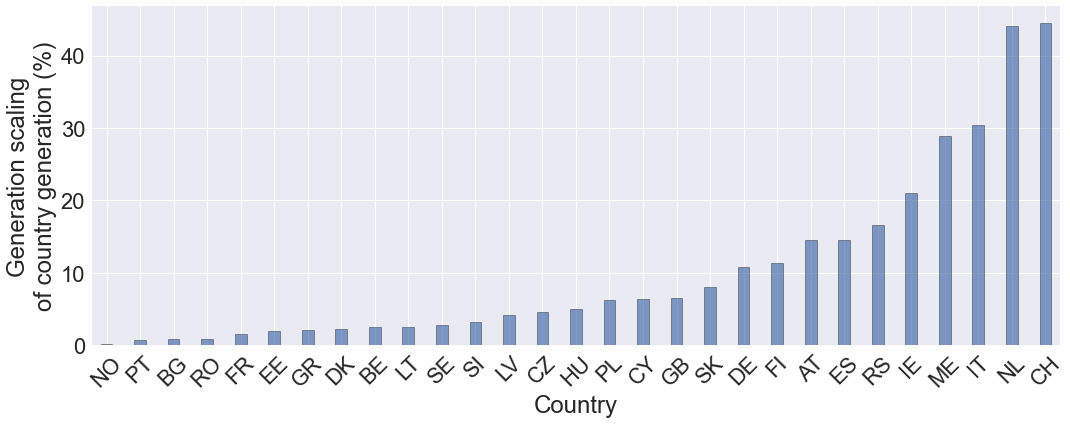

In [81]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 4).sort_values(by='diff_pro')['diff_pro'].multiply(100).plot(kind='bar',
                                                                     ylabel='Generation scaling (%)',
                                                                     linewidth=0.5,
                                                                     edgecolor='black',
                                                                     alpha=0.7,
                                                                     width=0.35,)
ax.set_xlabel("Country" , fontsize=24)
ax.set_ylabel("Generation scaling\nof country generation (%)", fontsize=24)

ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)


ax.tick_params(axis='x', rotation=45)


fig.tight_layout()
pass

In [82]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling.png'))

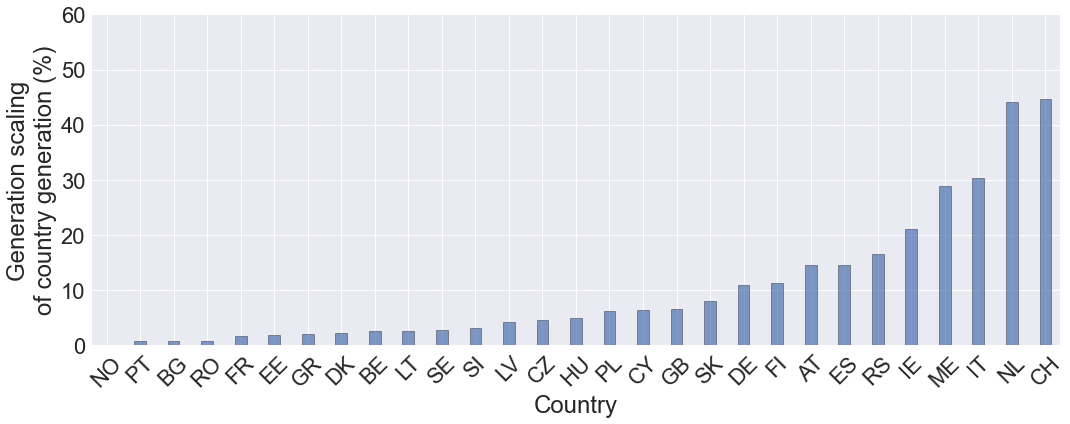

In [83]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 4).sort_values(by='diff_pro')['diff_pro'].multiply(100).plot(kind='bar',
                                                                     ylabel='Generation scaling (%)',
                                                                     linewidth=0.5,
                                                                     edgecolor='black',
                                                                     alpha=0.7,
                                                                     width=0.35,)

ax.set_xlabel("Country" , fontsize=24)
ax.set_ylabel("Generation scaling\nof country generation (%)", fontsize=24)

ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)




ax.tick_params(axis='x', rotation=45)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(0, 60)  # most of the data

fig.tight_layout()
pass

In [84]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling_zoom.png'))

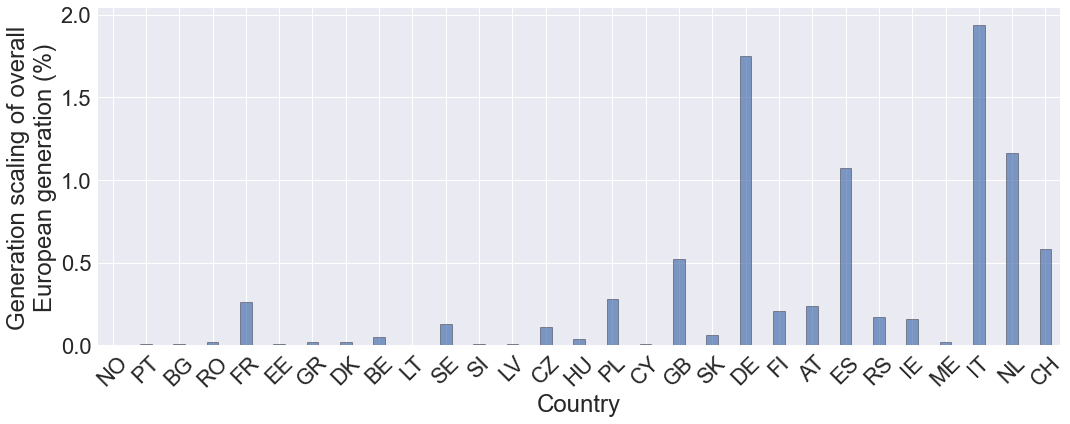

In [85]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 4).sort_values(by='diff_pro')['diff_pro_gen_all'].multiply(100).plot(kind='bar',
                                                                     ylabel='Generation scaling (%)',
                                                                     linewidth=0.5,
                                                                     edgecolor='black',
                                                                     alpha=0.7,
                                                                     width=0.35)

ax.set_xlabel("Country" , fontsize=24)
ax.set_ylabel("Generation scaling of overall\nEuropean generation (%)", fontsize=24)

ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)


ax.tick_params(axis='x', rotation=45)

fig.tight_layout()
pass

In [86]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling_realtion_all_gen.png'))

## Check data coverage in different data sets

In [87]:
def plot_n_compare(compare, unit='Generation (TWh)'):
    
    # make it eays to plot
    compare = (compare.unstack('Country').swaplevel(axis=1)
               .sort_index(axis=1).reindex(columns=None, level=1))
    
    sns.set_theme()
        
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'other': '#d35050',
              'waste': '#68896b',
              'wind_onshore': '#235ebc',
              'wind_offshore': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a',
              'other_renewable':'#08ad97'}
    
    compare.T.loc['ENTSO-E generation per unit'].plot(ax=ax,
                                kind='bar',
                                stacked=True,
                                legend=None,
                                position=1.5,
                                linewidth=0.5,
                                edgecolor='black',
                                alpha=0.7,
                                width=0.3,
                                color=[colors[col] for col in compare.T.loc['ENTSO-E generation per unit'].columns])    

    
    l1 = ax.legend(title="Technologies", loc='upper left', bbox_to_anchor=(0,1), frameon=True, framealpha=0.6, title_fontsize= 18, fontsize=16)
    
    plt.setp(l1.get_title())
    ax.add_artist(l1)
    
    compare.T.loc['ENTSO-E generation per type'].plot(ax=ax,
                                  hatch='/',
                                  kind='bar',
                                  stacked=True,
                                  position=0.5,
                                  linewidth=0.5,
                                  edgecolor='black',
                                  alpha=0.7,
                                  width=0.3,
                                  color=[colors[col] for col in compare.T.loc['ENTSO-E generation per type'].columns],
                                  legend=None)

    compare.T.loc['ENTSO-E generation statistical factsheet'].plot(ax=ax,
                                  hatch='//',
                                  kind='bar',
                                  stacked=True,
                                  position=-0.5,
                                  linewidth=0.5,
                                  edgecolor='black',
                                  alpha=0.7,
                                  width=0.30,
                                  color=[colors[col] for col in compare.T.loc['ENTSO-E generation statistical factsheet'].columns],
                                  legend=None)
    
    ax.set_xticklabels(compare.columns.levels[1].values, rotation=45, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)

    
    
    import matplotlib.patches as mpatches
    
    entsoe_unit_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E generation per unit',
                               hatch='', alpha=0.7, edgecolor='black')
    entsoe_type_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E generation per type',
                                hatch='/', alpha=0.7, edgecolor='black')
    entsoe_stats_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E generation statistical factsheet',
                                hatch='/', alpha=0.7, edgecolor='black')
    
    
    l2 = ax.legend(handles=[entsoe_unit_gen, entsoe_type_gen, entsoe_stats_gen],
                    handletextpad=0., columnspacing=0.5, ncol=1,
                    title='Datasets', title_fontsize= 18, fontsize=16, frameon=True, framealpha=0.6, loc="upper right")
    
    plt.setp(l2.get_title(), fontsize=18)
    ax.add_artist(l2)
    
    ax.set_xlabel('Country', fontsize=18)
    ax.set_ylabel(unit, fontsize=18)
    
    ax.set_xlim(-0.5, len(compare.columns.levels[1].values)-0.5)
    
    fig.tight_layout()
    
    return fig

In [88]:
generation_unit_info['generation'] = generation_per_unit_2018.sum()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

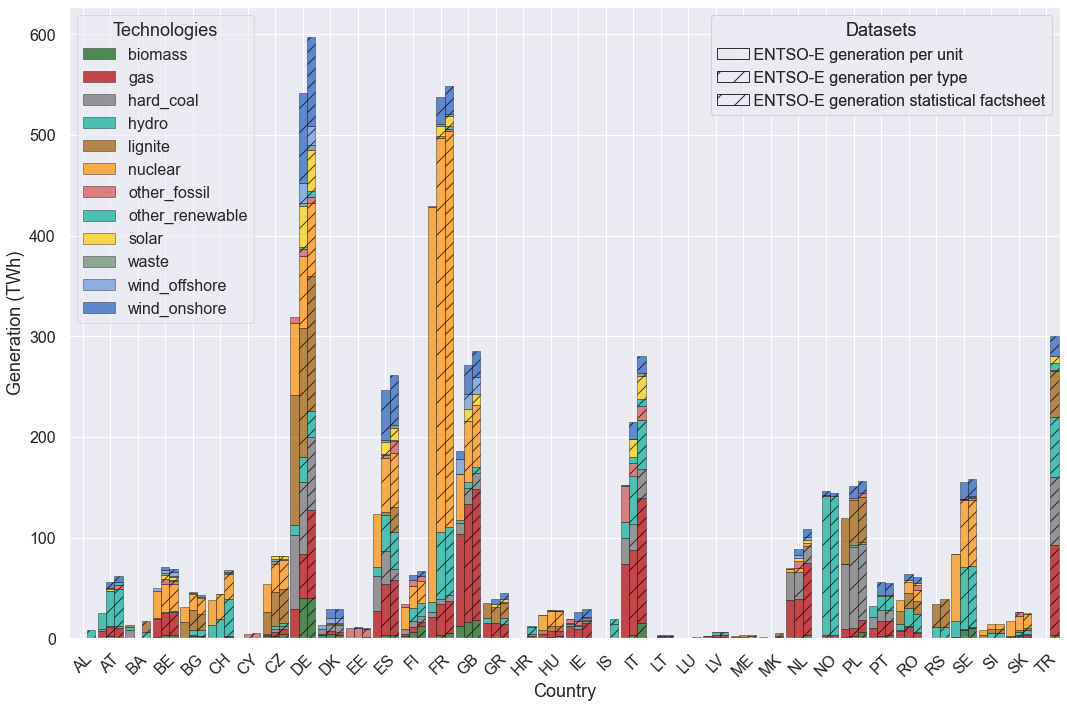

In [89]:
# filter to countries in the model
#filter_countries = generators.index.levels[0].to_list()

entsoe_unit_gen = generation_unit_info.groupby(['MapCode','ProductionTypeName']).sum()['generation']

entsoe_type_gen = entsoe_gen_type_table.sum()

entsoe_stats_gen = entsoe_stats.T

#entsoe_stats_cap.index = entsoe_stats_cap.index.remove_unused_levels()

# merge data 
compare = pd.concat([entsoe_unit_gen, entsoe_type_gen, entsoe_stats_gen], keys=['ENTSO-E generation per unit','ENTSO-E generation per type','ENTSO-E generation statistical factsheet'], axis=1)
# convert to GW
compare = compare / 1000000
compare.index.set_names(['Country','Technology'], level=[0,1], inplace=True)

# # filter all data with nan and 0
compare = compare.fillna(0)
compare[compare.sum(1) < 0.5] = np.nan

# # plot and save figure
fig = plot_n_compare(compare = compare, unit='Generation (TWh)')
fig.savefig(os.path.join(output_directory_path + '/_generation_compare_plot.png'), dpi=300)


In [90]:
def plot_n_compare_scaled(compare, unit='Generation (TWh)'):
    
    # make it eays to plot
    compare = (compare.unstack('Country').swaplevel(axis=1)
               .sort_index(axis=1).reindex(columns=None, level=1))
    
    sns.set_theme()
        
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'other': '#d35050',
              'waste': '#68896b',
              'wind_onshore': '#235ebc',
              'wind_offshore': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a',
              'other_renewable':'#08ad97'}
    
    compare.T.loc['ENTSO-E scaled'].plot(ax=ax,
                                kind='bar',
                                stacked=True,
                                legend=None,
                                position=1.5,
                                linewidth=0.5,
                                edgecolor='black',
                                alpha=0.7,
                                width=0.3,
                                color=[colors[col] for col in compare.T.loc['ENTSO-E scaled'].columns])    

    
    l1 = ax.legend(title="Technologies", loc='upper left', bbox_to_anchor=(0,1), frameon=True, framealpha=0.6, title_fontsize= 18, fontsize=16)
    
    plt.setp(l1.get_title())
    ax.add_artist(l1)
    
    compare.T.loc['ENTSO-E generation per type'].plot(ax=ax,
                                  hatch='/',
                                  kind='bar',
                                  stacked=True,
                                  position=0.5,
                                  linewidth=0.5,
                                  edgecolor='black',
                                  alpha=0.7,
                                  width=0.3,
                                  color=[colors[col] for col in compare.T.loc['ENTSO-E generation per type'].columns],
                                  legend=None)

    compare.T.loc['ENTSO-E generation statistical factsheet'].plot(ax=ax,
                                  hatch='//',
                                  kind='bar',
                                  stacked=True,
                                  position=-0.5,
                                  linewidth=0.5,
                                  edgecolor='black',
                                  alpha=0.7,
                                  width=0.30,
                                  color=[colors[col] for col in compare.T.loc['ENTSO-E generation statistical factsheet'].columns],
                                  legend=None)
    
    ax.set_xticklabels(compare.columns.levels[1].values, rotation=45, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    
    import matplotlib.patches as mpatches
    
    entsoe_unit_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E scaled',
                               hatch='', alpha=0.7, edgecolor='black')
    entsoe_type_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E generation per type',
                                hatch='/', alpha=0.7, edgecolor='black')
    entsoe_stats_gen = mpatches.Patch(facecolor='none', label=' ENTSO-E generation statistical factsheet',
                                hatch='/', alpha=0.7, edgecolor='black')
    
    
    l2 = ax.legend(handles=[entsoe_unit_gen, entsoe_type_gen, entsoe_stats_gen],
                    handletextpad=0., columnspacing=0.5, ncol=1,
                    title='Datasets', title_fontsize= 18, fontsize=16, frameon=True, framealpha=0.6, loc="upper right")
    
    plt.setp(l2.get_title(), fontsize=18)
    ax.add_artist(l2)
    
    ax.set_xlabel('Country', fontsize=18)
    ax.set_ylabel(unit, fontsize=18)
    
    ax.set_xlim(-0.5, len(compare.columns.levels[1].values)-0.5)
    
    fig.tight_layout()
    
    return fig

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

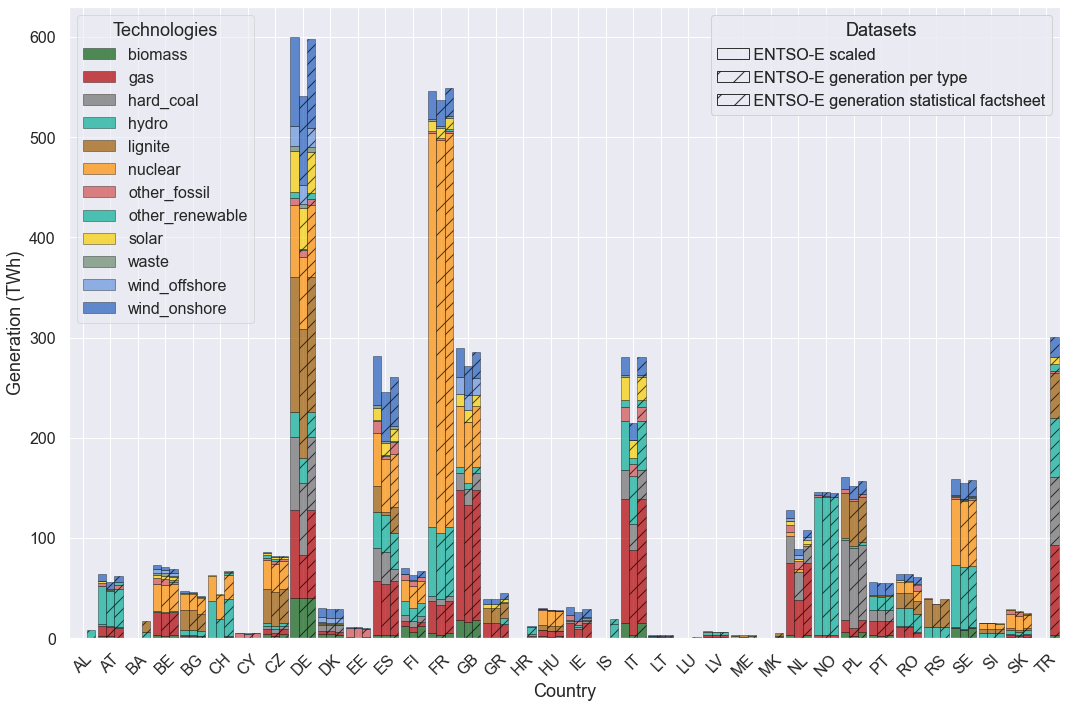

In [91]:
# filter to countries in the model
#filter_countries = generators.index.levels[0].to_list()

entsoe_type_gen = entsoe_gen_type_table.sum()

entsoe_stats_gen = entsoe_stats.T

entsoe_scaled_gen = entso_scaled.sum()

# merge data 
compare = pd.concat([entsoe_type_gen, entsoe_stats_gen, entsoe_scaled_gen], keys=['ENTSO-E generation per type','ENTSO-E generation statistical factsheet', 'ENTSO-E scaled'], axis=1)
# convert to GW
compare = compare / 1000000
compare.index.set_names(['Country','Technology'], level=[0,1], inplace=True)

# # filter all data with nan and 0
compare = compare.fillna(0)
compare[compare.sum(1) < 0.5] = np.nan

# # plot and save figure
fig = plot_n_compare_scaled(compare, unit='Generation (TWh)')
fig.savefig(os.path.join(output_directory_path + '/_generation_compare_plot_scaled.png'), dpi=300)

# Export datasets

In [92]:
entsoe_gen_type.to_csv(output_directory_path + '/entsoe_gen_type_hourly.csv')

In [93]:
entsoe_gen_type_table.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table.csv')

In [94]:
entso_scaled.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table_scaled.csv')

# Export tech Dic

In [95]:
dic = {
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}

In [96]:
pd.DataFrame.from_dict(dic, columns=['B'], orient='index').to_csv(output_directory_path + '/entso_gen_type_dic.csv')